In [1]:
import jax.numpy as jnp
from jax import random
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression

import dro_sweeps.classification_data_generation as cdg
import dro_sweeps.dro as dro
from dro_sweeps.plotting import plot_dataset

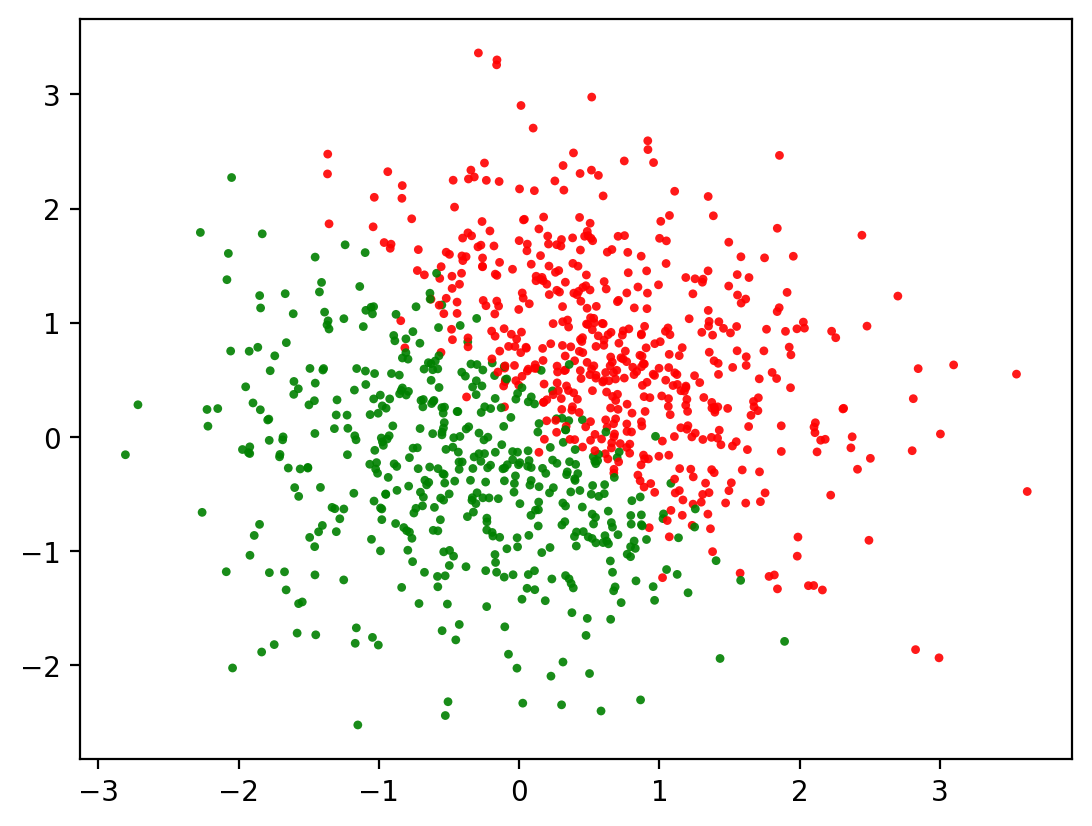

In [3]:
seed = 42069
key = random.PRNGKey(seed)
key, subkey = random.split(key)
inputs, labels = cdg.generate_dataset(subkey, [{
    'size': 1000,
    'input_mean': (0.2, 0.2),
    'input_covariance': ((1.0, 0.0), (0.0, 1.0)),
    'weights': jnp.array((0.5, 0.5, -0.2)),
    'noise_variance': 0.001,
}])

plot_dataset(inputs, labels)

/Users/kdbanman_ualberta/dev/dro_sweeps/env/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[[ 4.80279557  4.47814889 -1.79600203]]


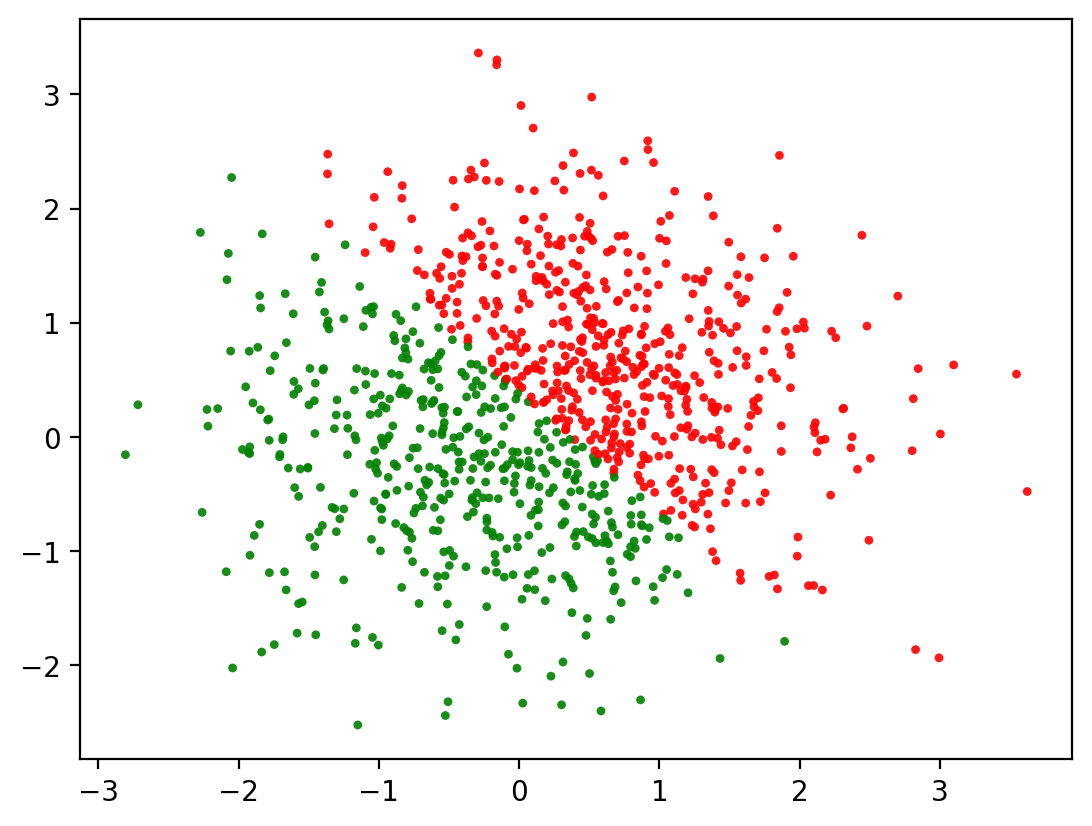

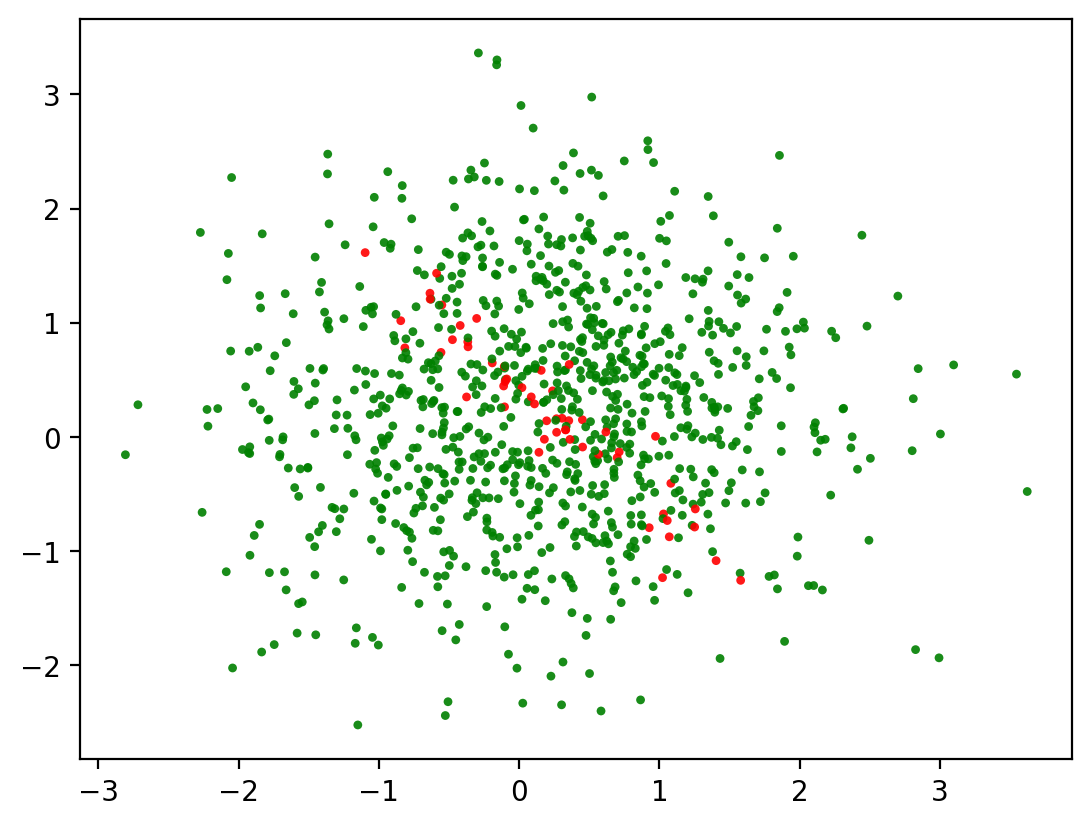

In [4]:
reference_model = LogisticRegression(
    random_state=0,
    tol=1e-7,
    fit_intercept=False,
    C=1.0,
    max_iter=1000
).fit(inputs, labels)

print(reference_model.coef_)

predictions = reference_model.predict(inputs).reshape((inputs.shape[0], 1))

plot_dataset(inputs, predictions)

false_predictions = jnp.logical_xor(labels, predictions)
plot_dataset(inputs, false_predictions.reshape((inputs.shape[0], 1)))

In [13]:
steps = 5e4
step_size = 1e-1
init_weights = jnp.array([0.1, 0.1, 0.1]).reshape((3, 1))

key, subkey = random.split(key)
weights, loss_trajectory, log_steps = dro.train_averaged_dro(
    key,
    inputs,
    labels,
    init_weights,
    cdg.logistic_outputs,
    dro.cross_entropy_loss,
    step_size,
    inputs.shape[0],
    1.0,
    steps,
    100,
)

print(weights)

[[ 7.1273046]
 [ 6.647946 ]
 [-2.7938442]]


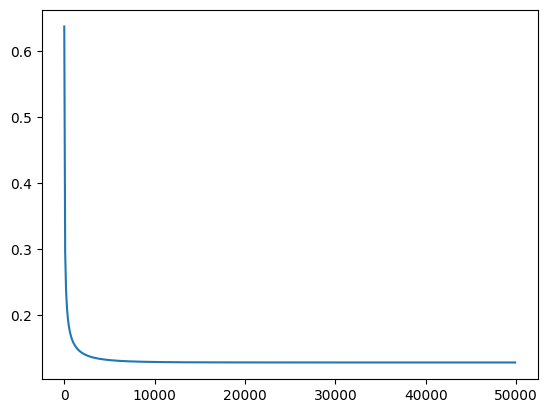

In [14]:
plt.plot(log_steps, loss_trajectory)

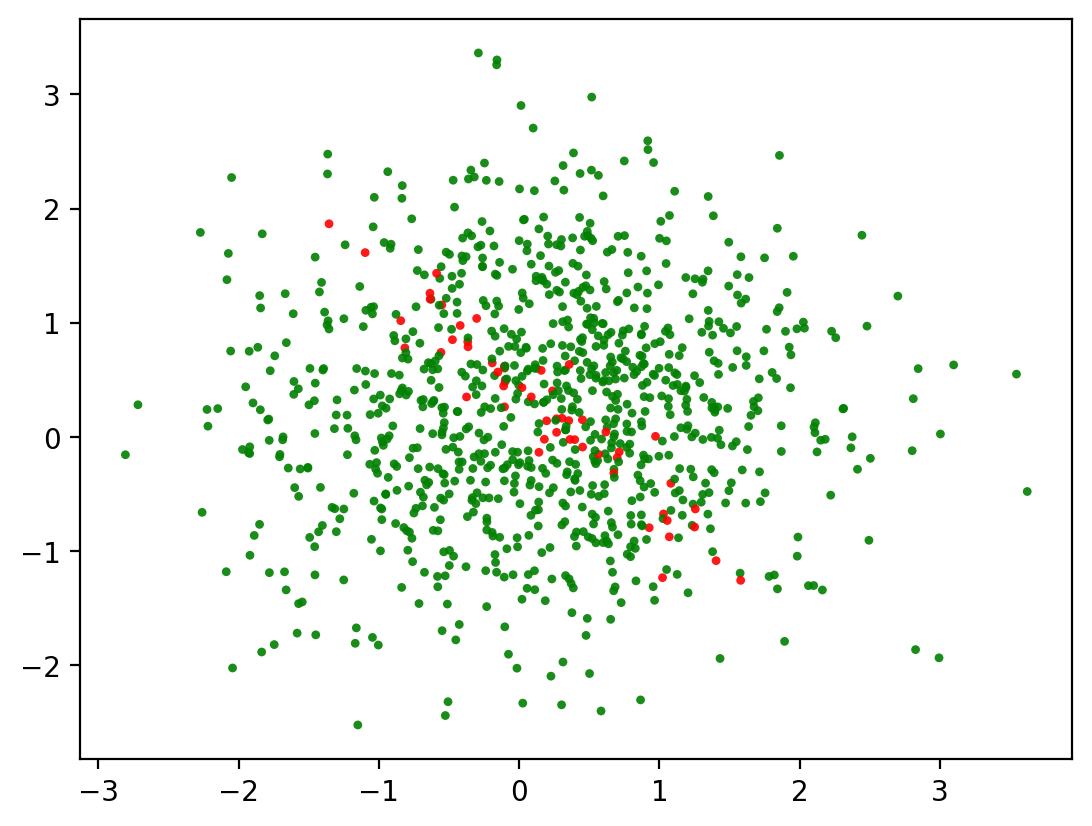

In [15]:
dro_predictions = cdg.logistic_outputs(inputs, weights) > 0.5
false_dro_predictions = jnp.logical_xor(dro_predictions, labels)
plot_dataset(inputs, false_dro_predictions)